In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
import string
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
!pip install -q -U keras-tuner
import keras_tuner as kt
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense, Embedding, GlobalMaxPool1D
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

tf.keras.utils.set_random_seed(7)
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
pd.set_option('max_colwidth', 600)
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
print("Device:", tpu.master())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 133 kB 5.0 MB/s 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.86.96.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.86.96.90:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Device: grpc://10.86.96.90:8470


In [2]:
pip install clean-text[gpl]


     |████████████████████████████████| 175 kB 5.3 MB/s 
     |████████████████████████████████| 53 kB 1.0 MB/s 
     |████████████████████████████████| 235 kB 48.9 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=8ef3d6f9c48198eb242a7035bfeb8a31743c0f04cba85c3d9a9e77304dff6460
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [3]:
from cleantext import clean

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [6]:
#mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
#Read in data
path_to_csv = '/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_4/cyberbullying_tweets.csv'
df=pd.read_csv(path_to_csv)

# Cleaning and Organizing Data

In [8]:
#looking at original data observation with emojis and urls

df.iloc[[706,1040]]

,tweet_text,cyberbullying_type
706,Uh. Why do they not make these for grownups? http://t.co/rHDOkljnDI,not_cyberbullying
1040,OMG 😱 I have a feeling I’m going to be overwhelmed 😱 by my emoticons in tomorrow’s #mkr 😱😰😅😜😀😩😨😱😱,not_cyberbullying


In [9]:
#function for cleaning data by removing emojies and urls with clean-text library. https://pypi.org/project/clean-text/

def cleaning_tweet_text(text):
    text= clean(text, no_emoji=True, no_urls=True, replace_with_url="") #removing emojies and urls 
    return text



In [10]:
#applying cleaning function to tweets
df["tweet_text"]=df["tweet_text"].apply(cleaning_tweet_text)

In [11]:
#checking the same observations as above after removing emojies and urls. We can see there are no longer
#any emojies or urls
df.iloc[[706,1040]]

,tweet_text,cyberbullying_type
706,uh. why do they not make these for grownups?,not_cyberbullying
1040,omg i have a feeling i'm going to be overwhelmed by my emoticons in tomorrow's #mkr,not_cyberbullying


In [12]:
#dropping duplicates
df = df.drop_duplicates(subset=['tweet_text'], keep='last')
df.shape

(45603, 2)

(45602, 3)

In [13]:
#checking distribution of cyberbyllying lables.
df["cyberbullying_type"].value_counts()

religion               7974
age                    7952
ethnicity              7946
other_cyberbullying    7720
gender                 7651
not_cyberbullying      6360
Name: cyberbullying_type, dtype: int64

In [14]:
#creating column of numerical cyberbullying labels.

label_number_mappings={"religion":0,
                       "age":1,
                       "gender":2,
                       "ethnicity":3,
                       "not_cyberbullying":4,
                       "other_cyberbullying":5
                      }
df["label_values"]=df["cyberbullying_type"].map(label_number_mappings)

In [15]:
#checking if mapping was properly done
df["label_values"].value_counts()

0    7974
1    7952
3    7946
5    7720
2    7651
4    6360
Name: label_values, dtype: int64

In [16]:
#Splitting dataset into full_train and test sets, stratifying on labels.

X_train_full, X_test, y_train_full, y_test = train_test_split(df["tweet_text"], df["label_values"], test_size=5000, stratify=df["label_values"])

In [ ]:
#making sure full train set is stratified properly
y_train_full.value_counts()

0    7100
1    7080
3    7075
5    6873
2    6812
4    5663
Name: label_values, dtype: int64

In [17]:
#making sure test set is stratified properly
y_test.value_counts()

0    874
1    872
3    871
5    847
2    839
4    697
Name: label_values, dtype: int64

In [18]:
#spliting full training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full,y_train_full, test_size=5000, stratify=y_train_full)

In [19]:
#making sure train set is stratified properly
y_train.value_counts()

0    6226
1    6208
3    6204
5    6026
2    5973
4    4966
Name: label_values, dtype: int64

In [20]:
#making sure validation set is stratified properly
y_val.value_counts()

0    874
1    872
3    871
5    847
2    839
4    697
Name: label_values, dtype: int64

# Data Preprocessing and Tokenization

In [21]:
#Tokenized text for X_train and X_val and X_test. Fit on train first then text_to_sequences on train,
#validation and test sets
max_tokens=30000
tokenizer =Tokenizer(num_words=max_tokens, oov_token="OOV")
tokenizer.fit_on_texts(X_train)
X_train_token=tokenizer.texts_to_sequences(X_train)
X_val_token=tokenizer.texts_to_sequences(X_val)
X_test_token=tokenizer.texts_to_sequences(X_test)

In [22]:
#check how many unique tokens
word_index=tokenizer.word_index
number_of_words=len(word_index)
print("Number of tokens",number_of_words )

Number of tokens 49098


In [23]:
#pad sequences for tokenized X_train, X_val and X_test
#set max length of text to 70 tokens
max_len=70
X_train_token_pad=pad_sequences(X_train_token, maxlen=max_len, padding="post", truncating="post")

X_val_token_pad=pad_sequences(X_val_token,maxlen= max_len , padding="post", truncating="post")
X_test_token_pad=pad_sequences(X_test_token,maxlen= max_len,padding="post", truncating="post")
X_val_token_pad.shape

(5000, 70)

# Helpful Model Fitting and Results Functions

In [24]:
#creating callback class to get the amount of seconds each epoch takes. Code from:
#https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit

class EpochTimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


In [25]:

def compile_train_model(model, x_train, y_train, x_valid, y_valid, model_num, epochs=100, patience=3, optimizer='adam'):
    timestamp=int(time.time())
    epoch_times=EpochTimeHistory()
  
    # Compile
    model.compile(optimizer=optimizer,
                loss = 'SparseCategoricalCrossentropy',
                metrics=['accuracy'])

  # Train
    start_time = time.time()
    history = model.fit(
      x_train,
      y_train,
      epochs=epochs,
      batch_size=128,
      validation_data=(x_valid, y_valid),
      verbose=1,
      callbacks=[    
          EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, verbose=0),
        epoch_times]
       )
    end_time = time.time()
    second_elapsed = round(end_time - start_time)
    epoch_times_values =epoch_times.times
    print("\n")
    print(f'Finished model training in {second_elapsed}s')
    print(f'Average time to run each epoch is: {  np.round(np.mean(epoch_times.times[1:-1]),4) }') 
                                                                       
  

    return history, model   

In [26]:
#Classificatin report function
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))#included per class instruction 

In [27]:
#function to print out training and validation set loss and accuracy values of the best model
def loss_accuracy_values(model_history, model_num, epochs, patience=3):  
  if len(model_history.history["val_loss"])==epochs:
      print("Model Experiment {} Training Loss: ".format(model_num),np.round(model_history.history["loss"][-1],4))
      print("Model Experiment {} Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-1],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num),np.round(model_history.history["val_loss"][-1],4))
      print("Model Experiment {}  Validation Accuracy: ".format(model_num),np.round(model_history.history["val_accuracy"][-1],4))
  else:
      print("Model Experiment {}  Training Loss: ".format(model_num),np.round(model_history.history["loss"][-(1+patience)],4))
      print("Model Experiment {}  Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-(1+patience)],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num), np.round(model_history.history["val_loss"][-(1+patience)],4))
      print("Model Experiment {}  Validation Accuracy:".format(model_num), np.round(model_history.history["val_accuracy"][-(1+patience)],4)) 

In [28]:
#creating function for charts of train vs validation accuracy and loss functions
def train_val_accuracy_and_loss_charts(model_history, model_num):
    model_df=pd.DataFrame(model_history.history)

    model_df[["loss","val_loss"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Loss".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    model_df[["accuracy","val_accuracy"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Accuracy".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    plt.show()    

In [29]:
# Function for creating multi-class confusion matrix

#class names for confusion matrix
class_names = ["religion",
                       "age",
                       "gender",
                       "ethnicity",
                       "not_cyberbullying",
                       "other_cyberbullying"
]



def confusion_matrix_multi_class(model_for_matrix,test_set, actual_test_labels, model_num):
    #predicting test set with model for confusion matrix and setting as sparse with argmax
    confusion_matrix_predictions=model_for_matrix.predict(test_set).argmax(axis=1)



    #creating confusion matrix - using test set labels as they were already sparse before one-hot encoding
    confusion_matrix_for_model = confusion_matrix( actual_test_labels ,  confusion_matrix_predictions)


    confusion_matrix_df = pd.DataFrame(confusion_matrix_for_model,
                    
                     index=class_names,
                     columns=class_names)

    #Plotting the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="rocket_r")
    plt.title('Confusion Matrix - Model Experiment {}'.format(model_num), size=17)
    plt.ylabel('Actual Labels', size=15)
    plt.xlabel('Predicted Labels',size=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

# Experiment 2_A - LSTM - Hyperparameter Tuning - Up to 3 LSTM Layers with Dropout

In [30]:
#Experiment 2_A model 
#create model for KerasTuner hyperparameter testing
def create_model_exp_2_A(hp):
    
    model=Sequential()
    #tunning for different number of embedding output dimensions min of 100, max of 400 and any in between by multiples of 100
    model.add(Embedding(input_dim=max_tokens+2, output_dim= hp.Int(f"Embedding_Output_Dimension", min_value=100, max_value=400, step=100),mask_zero=True))
    #tunning for a choice of 1 or 2  LSTM layers. There is an additional LSTM layer that must be outside the loop as it needs
    #to not have return_sequences =True
    
    for i in range(hp.Int("number_layers",1,2)):
        #within each LSTM layer testing for a min of 64 units, a max of 256 nodes and any in between by 
        #multiples of 32. 
        model.add(LSTM(units=hp.Int('LSTM_{}_units'.format(i),min_value=64,max_value=256,step=32),return_sequences=True))
        #testing for dropout of values 0.1 to 0.4 by increments of 0.1 after every hidden layer
        model.add(Dropout (hp.Float("dropout_{}".format(i), min_value=0.10, max_value=0.40, step=0.10)))
        
    #For last LSTM layer testing for a min of 64 units, a max of 256 nodes and any in between by 
    #multiples of 32
    model.add(LSTM(units=hp.Int('LSTM_{}_units'.format(i+1),min_value=64,max_value=256,step=32)))
    #testing for dropout of values 0.1 to 0.4 by increments of 0.1 after every hidden layer
    model.add(Dropout (hp.Float("dropout_{}".format(i+1), min_value=0.10, max_value=0.40, step=0.10)))
    model.add(Dense(6, activation="softmax"))    
    
    #testing for optimizer choice of adam, sgd, or rmsprop
    model.compile(optimizer=hp.Choice("optimizer", ["adam", "sgd", "rmsprop"]), \
                                            loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [31]:
strategy_exp_2_A  = tf.distribute.TPUStrategy(tpu) 

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [32]:
#creating Bayesian Optimization for KerasTuner
tuner_exp_2_A = kt.BayesianOptimization(
    hypermodel=create_model_exp_2_A,
    objective="val_accuracy",
    max_trials=15,
    overwrite=True,
    distribution_strategy=strategy_exp_2_A,
    directory='/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_4/keras_tuner_out',
    project_name="exp_2_A")

In [33]:
#setting epochs, patience and early stopping
epochs=30
patience=3
model_number="2_A"
early_stopping= EarlyStopping(monitor='val_accuracy',patience=patience, restore_best_weights=True )

#tunning the model
tuner_exp_2_A.search(X_train_token_pad, y_train, epochs=epochs, batch_size=128, validation_data=(X_val_token_pad, y_val), callbacks= [early_stopping])


Trial 15 Complete [00h 01m 50s]
val_accuracy: 0.8772000074386597

Best val_accuracy So Far: 0.8853999972343445
Total elapsed time: 00h 31m 05s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [34]:
#getting best hyperparameters
best_hyper_parameters_exp_2_A=tuner_exp_2_A.get_best_hyperparameters(num_trials=1)[0]

#function to print out best parameters depending on how many LSTM layers there are
def best_model_hyperparameters_exp_2_A(bhp):
    print("Embedding_Output_Dimension: {}".format(bhp.get('Embedding_Output_Dimension')))
    num_layers=bhp.get('number_layers')
    print("Number of layers: {}".format(num_layers+1))
    print("\n")
    for i in range(0,num_layers+1):
        print("Number of units in LSTM_{}:".format(i), bhp.get("LSTM_{}_units".format(i)))
        print("Dropout in LSTM_{}:".format(i),np.round( bhp.get("dropout_{}".format(i)),3 )  )
        print("\n")
    print("Optimizer Used: {}".format(bhp.get('optimizer')))                                                           

#printing out best model hyperparameters
best_model_hyperparameters_exp_2_A(best_hyper_parameters_exp_2_A)   

Embedding_Output_Dimension: 400
Number of layers: 2


Number of units in LSTM_0: 64
Dropout in LSTM_0: 0.1


Number of units in LSTM_1: 256
Dropout in LSTM_1: 0.1


Optimizer Used: rmsprop


In [35]:
#setting up TPU strategy to run best 2_A model
strategy_2_A_best = tf.distribute.TPUStrategy(tpu) 

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [41]:
#getting paremeters of best model
model_exp_2_A_best_params = tuner_exp_2_A.get_best_hyperparameters(2)
# Building model exp_2_A with best hyper parameters
with strategy_2_A_best.scope():
    model_exp_2_A_best = create_model_exp_2_A(model_exp_2_A_best_params[0])


In [42]:


# Running best model 2_A to get the time to run an epoch and time to run the whole model. Test set metrics will be 
#based of this model run.
epochs=30
patience=3
model_number="2_A"
history_exp_2_A, model_exp_2_A = compile_train_model(model_exp_2_A_best,
                                    X_train_token_pad,y_train,
                                     X_val_token_pad,y_val, model_number, epochs,patience=patience,
                                    optimizer="rmsprop")

Epoch 1/30
  5/279 [..............................] - ETA: 10s - loss: 1.8268 - accuracy: 0.2297WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_train_batch_end` time: 1.0468s). Check your callbacks.


279/279 [==============================] - 35s 80ms/step - loss: 0.5610 - accuracy: 0.7932 - val_loss: 0.3607 - val_accuracy: 0.8674
Epoch 2/30
279/279 [==============================] - 11s 40ms/step - loss: 0.2845 - accuracy: 0.8994 - val_loss: 0.3489 - val_accuracy: 0.8728
Epoch 3/30
279/279 [==============================] - 11s 41ms/step - loss: 0.2165 - accuracy: 0.9242 - val_loss: 0.3542 - val_accuracy: 0.8844
Epoch 4/30
279/279 [==============================] - 11s 40ms/step - loss: 0.1744 - accuracy: 0.9394 - val_loss: 0.3666 - val_accuracy: 0.8788
Epoch 5/30
279/279 [==============================] - 11s 40ms/step - loss: 0.1445 - accuracy: 0.9501 - val_loss: 0.4176 - val_accuracy: 0.8704
Epoch 6/30
279/279 [==============================] - 12s 42ms/step - loss: 0.1215 - accuracy: 0.9579 - val_loss: 0.3979 - val_accuracy: 0.8740


Finished model training in 93s
Average time to run each epoch is: 11.3236


In [43]:
model_exp_2_A.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 400)         12000800  
                                                                 
 lstm_6 (LSTM)               (None, None, 64)          119040    
                                                                 
 dropout_6 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_7 (LSTM)               (None, 256)               328704    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 12,450,086
Trainable params: 12,450,086


In [44]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_2_A, model_number, epochs, patience=patience)

Model Experiment 2_A  Training Loss:  0.2165
Model Experiment 2_A  Training Accuracy:  0.9242
Model Experiment 2_A  Validation Loss:  0.3542
Model Experiment 2_A  Validation Accuracy: 0.8844


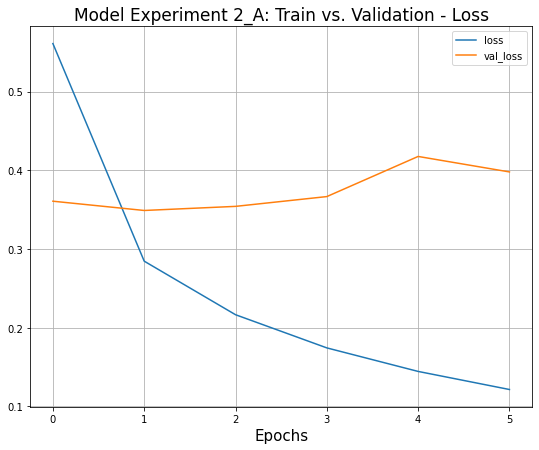

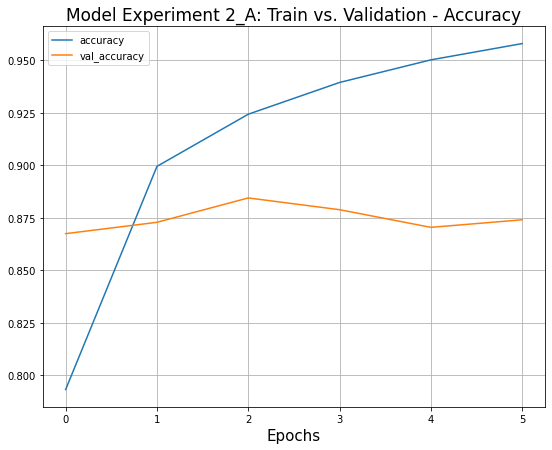

In [45]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_2_A, model_number)

In [46]:
#creating  classification report

#getting predictions

model_exp_2_A_predictions=model_exp_2_A.predict(X_test_token_pad).argmax(axis=1)
print_validation_report(y_test, model_exp_2_A_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       874
           1       0.97      0.98      0.97       872
           2       0.80      0.92      0.86       839
           3       0.98      0.97      0.98       871
           4       0.73      0.59      0.65       697
           5       0.78      0.76      0.77       847

    accuracy                           0.88      5000
   macro avg       0.87      0.87      0.86      5000
weighted avg       0.87      0.88      0.87      5000

Accuracy Score: 0.8754
Root Mean Square Error: 0.8349850298059242


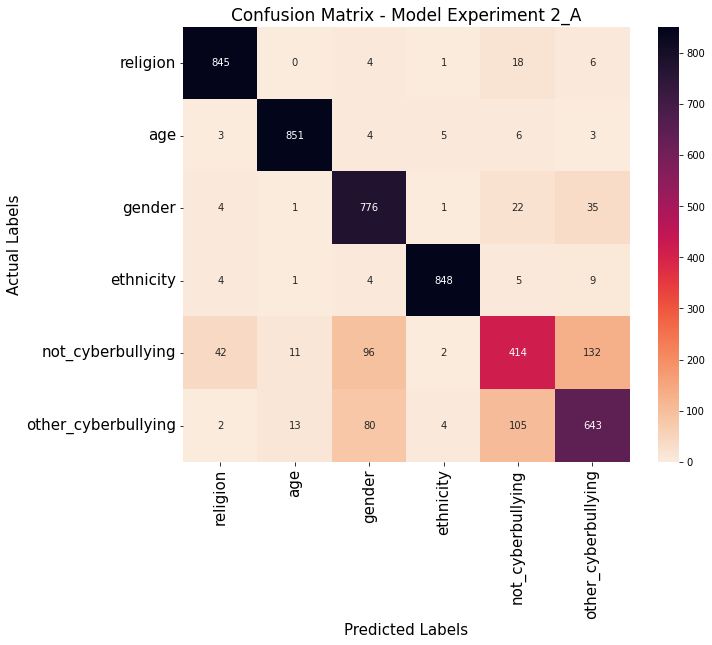

In [47]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_2_A, X_test_token_pad, y_test, model_number)

# Experiment 2_B - GRU - Hyperparameter Tuning - Up to 3 GRU Layers with Dropout

In [48]:
keras.backend.clear_session()

In [49]:
#Experiment 2_B model 
#create model for KerasTuner hyperparameter testing
def create_model_exp_2_B(hp):
    
    model=Sequential()
    #tunning for different number of embedding output dimensions min of 100, max of 400 and any in between by multiples of 100
    model.add(Embedding(input_dim=max_tokens+2, output_dim= hp.Int(f"Embedding_Output_Dimension", min_value=100, max_value=400, step=100),mask_zero=True))
    #tunning for a choice of 1 or 2 GRU layers. There is an additional GRU layer that must be outside the loop as it needs
    #to not have return_sequences =True
    
    for i in range(hp.Int("number_layers",1,2)):
        #within each GRU layer testing for a min of 64 units, a max of 256 nodes and any in between by 
        #multiples of 32. 
        model.add(GRU(units=hp.Int('GRU_{}_units'.format(i),min_value=64,max_value=256,step=32),return_sequences=True))
        #testing for dropout of values 0.1 to 0.4 by increments of 0.1 after every hidden layer
        model.add(Dropout (hp.Float("dropout_{}".format(i), min_value=0.10, max_value=0.40, step=0.10)))
        
    #For last GRU layer testing for a min of 64 units, a max of 256 nodes and any in between by 
    #multiples of 32
    model.add(GRU(units=hp.Int('GRU_{}_units'.format(i+1),min_value=64,max_value=256,step=32)))
    #testing for dropout of values 0.1 to 0.4 by increments of 0.1 after every hidden layer
    model.add(Dropout (hp.Float("dropout_{}".format(i+1), min_value=0.10, max_value=0.40, step=0.10)))
    model.add(Dense(6, activation="softmax"))    
    
    #testing for optimizer choice of adam, sgd, or rmsprop
    model.compile(optimizer=hp.Choice("optimizer", ["adam", "sgd", "rmsprop"]), \
                                            loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [50]:
strategy_exp_2_B  = tf.distribute.TPUStrategy(tpu) 

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [53]:
#creating Bayesian Optimization for KerasTuner
tuner_exp_2_B = kt.BayesianOptimization(
    hypermodel=create_model_exp_2_B,
    objective="val_accuracy",
    max_trials=15,
    overwrite=True,
    distribution_strategy=strategy_exp_2_B,
    directory='/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_4/keras_tuner_out',
    project_name="exp_2_b")

In [54]:
#setting epochs, patience and early stopping
epochs=30
patience=3
model_number="2_B"
early_stopping= EarlyStopping(monitor='val_accuracy',patience=patience, restore_best_weights=True )

#tunning the model
tuner_exp_2_B.search(X_train_token_pad, y_train, epochs=epochs, batch_size=128, validation_data=(X_val_token_pad, y_val), callbacks= [early_stopping])


Trial 15 Complete [00h 01m 52s]
val_accuracy: 0.8765999674797058

Best val_accuracy So Far: 0.8797999620437622
Total elapsed time: 00h 30m 47s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [55]:
#getting best hyperparameters
best_hyper_parameters_exp_2_B=tuner_exp_2_B.get_best_hyperparameters(num_trials=1)[0]

#function to print out best parameters depending on how many GRU layers there are
def best_model_hyperparameters_exp_2_B(bhp):
    print("Embedding_Output_Dimension: {}".format(bhp.get('Embedding_Output_Dimension')))
    num_layers=bhp.get('number_layers')
    print("Number of layers: {}".format(num_layers+1))
    print("\n")
    for i in range(0,num_layers+1):
        print("Number of units in GRU_{}:".format(i), bhp.get("GRU_{}_units".format(i)))
        print("Dropout in GRU_{}:".format(i),np.round( bhp.get("dropout_{}".format(i)),3 )  )
        print("\n")
    print("Optimizer Used: {}".format(bhp.get('optimizer')))                                                           

#printing out best model hyperparameters
best_model_hyperparameters_exp_2_B(best_hyper_parameters_exp_2_B)   

Embedding_Output_Dimension: 100
Number of layers: 3


Number of units in GRU_0: 64
Dropout in GRU_0: 0.4


Number of units in GRU_1: 224
Dropout in GRU_1: 0.1


Number of units in GRU_2: 64
Dropout in GRU_2: 0.1


Optimizer Used: rmsprop


In [56]:
#setting up TPU strategy to run best 2_B model
strategy_2_B_best = tf.distribute.TPUStrategy(tpu) 

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [61]:
#getting paremeters of best model
model_exp_2_B_best_params = tuner_exp_2_B.get_best_hyperparameters(2)
# Building model exp_2_B with best hyper parameters
with strategy_2_B_best.scope():
    model_exp_2_B_best = create_model_exp_2_B(model_exp_2_B_best_params[0])


In [62]:

# Running best model 2_B to get the time to run an epoch and time to run the whole model. Test set metrics will be 
#based of this model run.
epochs=30
patience=3
model_number="2_B"
history_exp_2_B, model_exp_2_B = compile_train_model(model_exp_2_B_best,
                                    X_train_token_pad,y_train,
                                     X_val_token_pad,y_val, model_number, epochs,patience=patience,
                                    optimizer="rmsprop")

Epoch 1/30
  5/279 [..............................] - ETA: 9s - loss: 1.7856 - accuracy: 0.2422WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_train_batch_end` time: 0.9166s). Check your callbacks.


279/279 [==============================] - 36s 78ms/step - loss: 0.6671 - accuracy: 0.7376 - val_loss: 0.3940 - val_accuracy: 0.8542
Epoch 2/30
279/279 [==============================] - 11s 38ms/step - loss: 0.3470 - accuracy: 0.8738 - val_loss: 0.3806 - val_accuracy: 0.8652
Epoch 3/30
279/279 [==============================] - 11s 38ms/step - loss: 0.2633 - accuracy: 0.9092 - val_loss: 0.4842 - val_accuracy: 0.8444
Epoch 4/30
279/279 [==============================] - 11s 38ms/step - loss: 0.2185 - accuracy: 0.9253 - val_loss: 0.3450 - val_accuracy: 0.8776
Epoch 5/30
279/279 [==============================] - 11s 38ms/step - loss: 0.1853 - accuracy: 0.9371 - val_loss: 0.3770 - val_accuracy: 0.8720
Epoch 6/30
279/279 [==============================] - 11s 38ms/step - loss: 0.1607 - accuracy: 0.9467 - val_loss: 0.3973 - val_accuracy: 0.8700
Epoch 7/30
279/279 [==============================] - 11s 39ms/step - loss: 0.1446 - accuracy: 0.9514 - val_loss: 0.4859 - val_accuracy: 0.8492


F

In [63]:
model_exp_2_B.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         3000200   
                                                                 
 gru_9 (GRU)                 (None, None, 64)          31872     
                                                                 
 dropout_9 (Dropout)         (None, None, 64)          0         
                                                                 
 gru_10 (GRU)                (None, None, 224)         194880    
                                                                 
 dropout_10 (Dropout)        (None, None, 224)         0         
                                                                 
 gru_11 (GRU)                (None, 64)                55680     
                                                                 
 dropout_11 (Dropout)        (None, 64)               

In [64]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_2_B, model_number, epochs, patience=patience)

Model Experiment 2_B  Training Loss:  0.2185
Model Experiment 2_B  Training Accuracy:  0.9253
Model Experiment 2_B  Validation Loss:  0.345
Model Experiment 2_B  Validation Accuracy: 0.8776


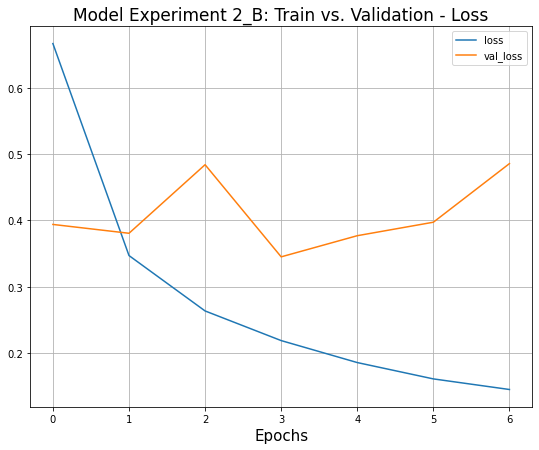

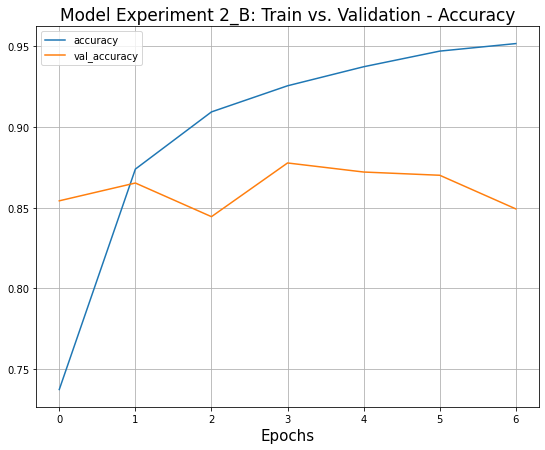

In [65]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_2_B, model_number)

In [66]:
#creating  classification report

#getting predictions

model_exp_2_B_predictions=model_exp_2_B.predict(X_test_token_pad).argmax(axis=1)
print_validation_report(y_test, model_exp_2_B_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       874
           1       0.97      0.98      0.97       872
           2       0.83      0.92      0.87       839
           3       0.98      0.97      0.98       871
           4       0.70      0.61      0.65       697
           5       0.76      0.75      0.75       847

    accuracy                           0.87      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.87      0.87      0.87      5000

Accuracy Score: 0.8734
Root Mean Square Error: 0.8286132994346639


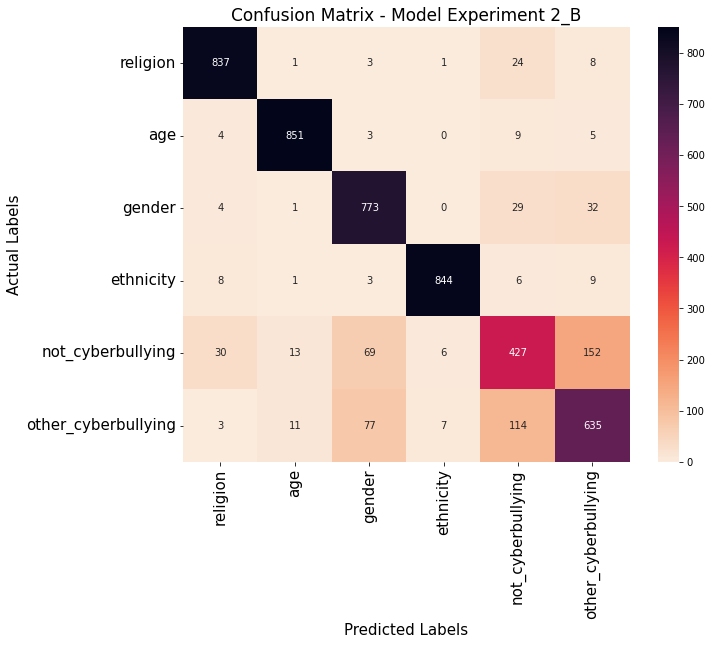

In [67]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_2_B, X_test_token_pad, y_test, model_number)